In [60]:
#Group project DSCI 100 Group #3

# Testing if github collaboration works

library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

# Classifying Stellar Observations


Main question: Is _____ a star, galaxy, or quasar?


Dataset of interest: 2017 Stellar Classification (SDSS17) https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17

Preliminary exploratory data analysis: the cell below demonstrates reading our data into R.



In [72]:
star_data <- read_csv("https://raw.githubusercontent.com/Margokap/DSCI100-group-03/main/star_classification.csv")
## clean data (use tidy data criteria); 
# each row is a single observation,
# each column is a single variable, and
# each value is a single cell (i.e., its entry in the data frame is not shared with another value).

##tidying data:

star_data_tidy <- mutate(star_data, ascension_angle = alpha, declination_angle = delta,
                        ultraviolet_filter = u, green_filter = g, red_filter = r,
                        near_infrared_filter = i, infrared_filter = z, class = as.factor(class))
(star_data_tidy <- select(star_data_tidy, ascension_angle, declination_angle, ultraviolet_filter, green_filter, 
                          red_filter, near_infrared_filter, infrared_filter, redshift, class))



Rows: 100000 Columns: 18
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): class
dbl (17): obj_ID, alpha, delta, u, g, r, i, z, run_ID, rerun_ID, cam_col, fi...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


ascension_angle,declination_angle,ultraviolet_filter,green_filter,red_filter,near_infrared_filter,infrared_filter,redshift,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
135.6891,32.49463,23.87882,22.27530,20.39501,19.16573,18.79371,0.6347936,GALAXY
144.8261,31.27418,24.77759,22.83188,22.58444,21.16812,21.61427,0.7791360,GALAXY
142.1888,35.58244,25.26307,22.66389,20.60976,19.34857,18.94827,0.6441945,GALAXY
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
224.5874,15.70071,21.16916,19.26997,18.20428,17.69034,17.35221,0.1433656,GALAXY
212.2686,46.66037,25.35039,21.63757,19.91386,19.07254,18.62482,0.4550396,GALAXY
196.8961,49.46464,22.62171,21.79745,20.60115,20.00959,19.28075,0.5429442,GALAXY


class,mean_ascension_angle,mean_declination_angle,mean_ultraviolet_filter,mean_green_filter,mean_red_filter,mean_near_infrared_filter,mean_infrared_filter,mean_redshift,number_of_stellar_type
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
GALAXY,180.5790,23.18619,22.47404,20.70070,19.54001,18.83777,18.42611,0.4446419971,49
QSO,172.5699,24.71965,21.70679,21.07213,20.75463,20.59041,20.39419,1.6460702706,51
STAR,185.5713,19.28328,21.13827,19.55868,18.85664,18.50167,18.21548,-0.0001165901,49


,ascension_angle,declination_angle,ultraviolet_filter,green_filter,red_filter,near_infrared_filter,infrared_filter,redshift
ascension_angle,1.000000000,-0.003006772,-0.03597242,-0.052251225,-0.06224213,-0.04637056,-0.05793011,-0.1059644
declination_angle,-0.003006772,1.000000000,-0.06046976,0.006810851,-0.00238502,-0.02917482,-0.02028491,0.0705541
ultraviolet_filter,-0.035972422,-0.060469765,1.00000000,0.869164695,0.74806512,0.64179796,0.58414044,0.1374253
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
near_infrared_filter,-0.04637056,-0.02917482,0.6417980,0.8719254,0.9701977,1.0000000,0.9828767,0.5359540
infrared_filter,-0.05793011,-0.02028491,0.5841404,0.8225377,0.9425407,0.9828767,1.0000000,0.5448683
redshift,-0.10596439,0.07055410,0.1374253,0.3354054,0.4653898,0.5359540,0.5448683,1.0000000


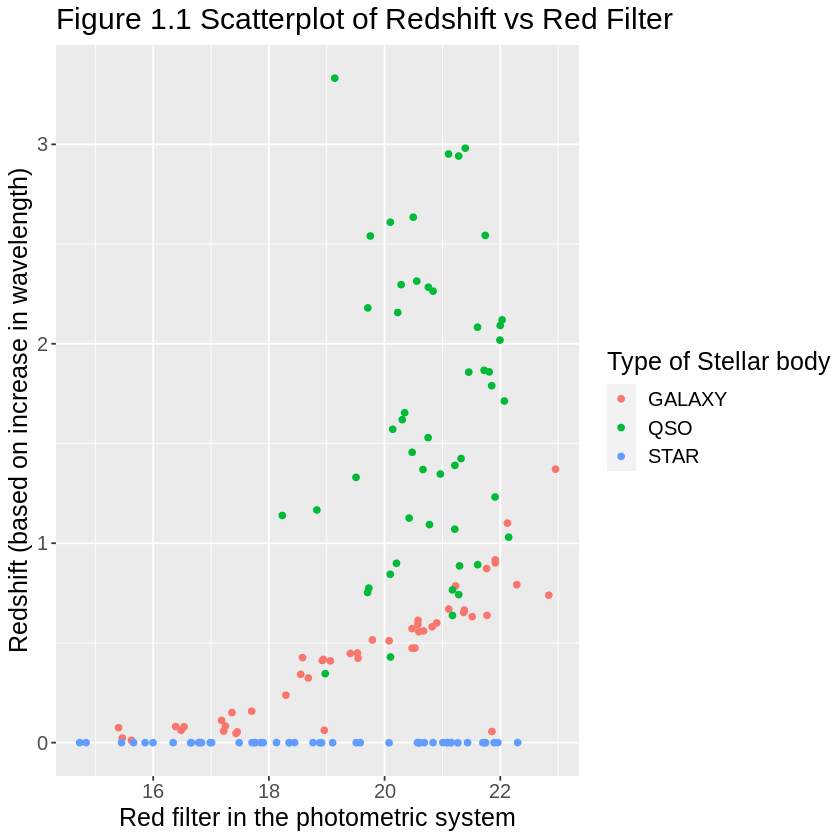

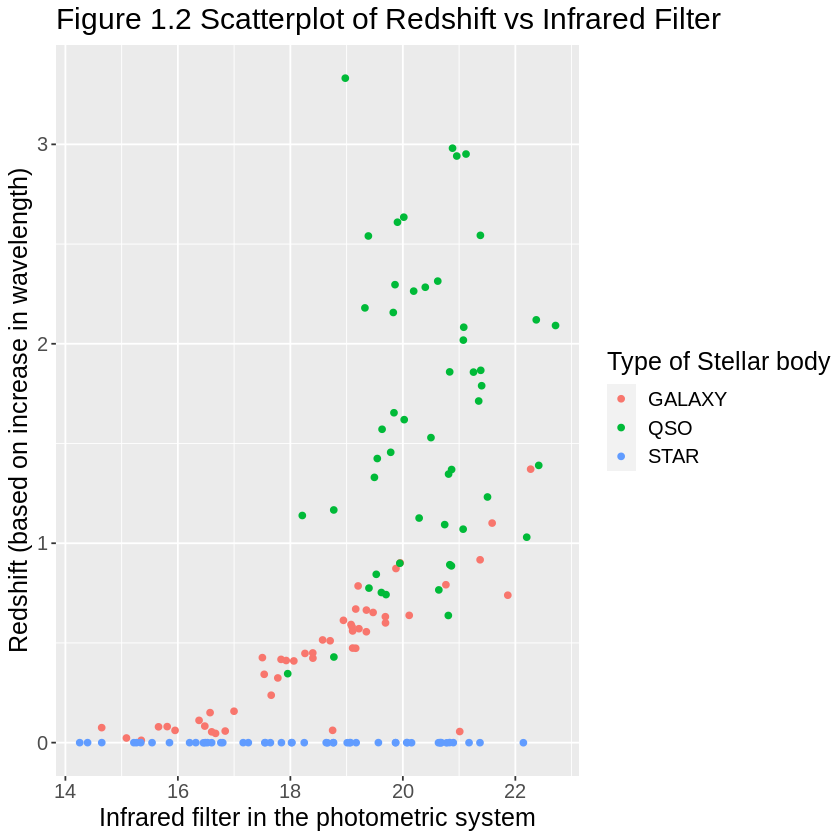

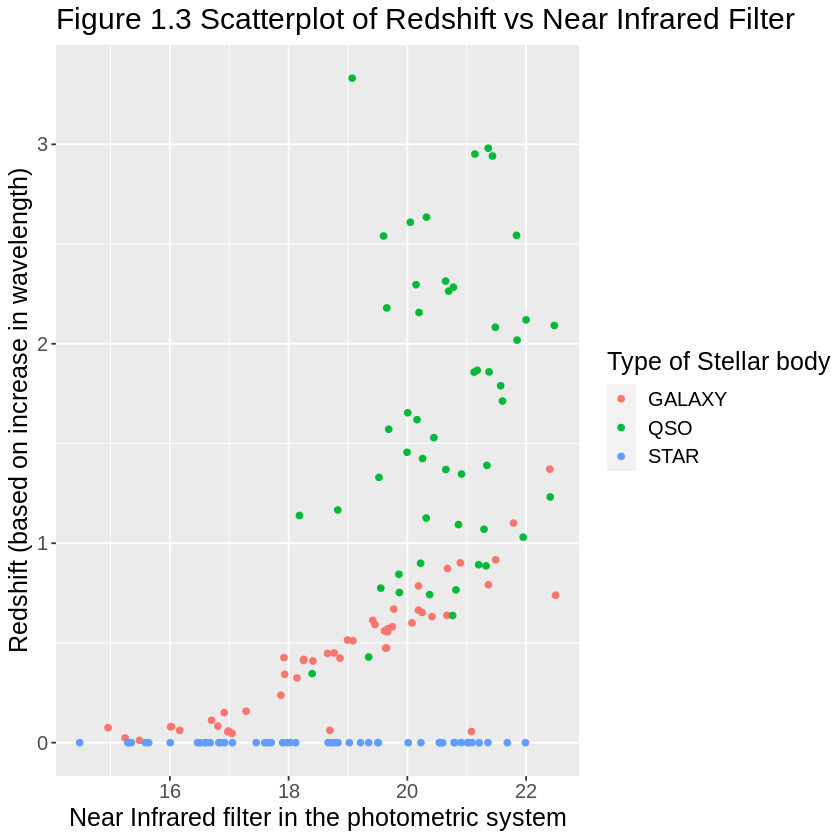

In [85]:
#sampling from data to make data balanced
star_data_star <- star_data_tidy |>
                  filter(class == "STAR") |>
                  sample_n(150)

star_data_galaxy <- star_data_tidy |>
                  filter(class == "GALAXY") |>
                  sample_n(150)

star_data_qso <- star_data_tidy |>
                  filter(class == "QSO") |>
                  sample_n(150)

star_data_balanced <- rbind(star_data_qso, star_data_galaxy, star_data_star) |>
                  sample_n(200)

#Split Train and Testing data
star_split <- initial_split(star_data_balanced, prop = 0.75, strata = class)
star_training <- training(star_split)
star_testing <- testing(star_split)

star_table <- star_training |>
              group_by(class) |>
              summarize(mean_ascension_angle = mean(ascension_angle), mean_declination_angle = mean(declination_angle),
                        mean_ultraviolet_filter = mean(ultraviolet_filter), mean_green_filter = mean(green_filter),
                        mean_red_filter = mean(red_filter), mean_near_infrared_filter = mean(near_infrared_filter), mean_infrared_filter = mean(infrared_filter),
                        mean_infrared_filter = mean(infrared_filter), mean_redshift = mean(redshift), number_of_stellar_type = n())
star_table

# correlation between variables
cor(select(star_training, -class))

(redshit_vs_red_filter <- ggplot(star_training, aes(y = redshift, x = red_filter, color = class)) +
                              geom_point() +
                              labs(y = "Redshift (based on increase in wavelength)", x = "Red filter in the photometric system", color = "Type of Stellar body") +
                            theme(text = element_text(size = 15)) +
                            ggtitle("Figure 1.1 Scatterplot of Redshift vs Red Filter"))

(redshit_vs_infrared <- ggplot(star_training, aes(y = redshift, x = infrared_filter, color = class)) +
                              geom_point() +
                              labs(y = "Redshift (based on increase in wavelength)", x = "Infrared filter in the photometric system", color = "Type of Stellar body") +
                            theme(text = element_text(size = 15)) +
                            ggtitle("Figure 1.2 Scatterplot of Redshift vs Infrared Filter"))
(redshit_vs_near_infrared <- ggplot(star_training, aes(y = redshift, x = near_infrared_filter, color = class)) +
                              geom_point() +
                              labs(y = "Redshift (based on increase in wavelength)", x = "Near Infrared filter in the photometric system", color = "Type of Stellar body") +
                            theme(text = element_text(size = 15)) +
                            ggtitle("Figure 1.3 Scatterplot of Redshift vs Near Infrared Filter"))


Methods:

We will use xyz column to analyze our data. In particular, we will perform a classification to predict a category for a new observation using past observations of known class. In particular, we will predict xyz based on past observations of described class of xyz. 

Expected outcomes and significance:

What do you expect to find?
What impact could such findings have?
What future questions could this lead to?